# CSV Input Pipeline for an $\mathbb R^2$ Binary Classifier  

## Objectives
- Construst a robust input pipeline to read in the CSV files generated by *generate_data.ipynb*.
- Use TensorFlow's `QueueRunners` to prepare shuffled mini-batches of examples from those files.
- Flesh out the skeletal framework from *apparatus-1.ipynb* with a pauseable logistic regression classifier.

## The Input Pipeline

Note: Don't run this notebook until you've run *generate_data.ipynb* at least once first to create the directory of data files.

In [1]:
import os
import tensorflow as tf
notebook_dir = "cluster2D"
g = tf.Graph()

### Mini-batch Design Matrix

Get the list of .csv files in the `notebook_dir`.

In [2]:
csv_file_list = [os.path.join(notebook_dir, x) for x in os.listdir(notebook_dir) if x.endswith('.csv')]
csv_file_list

['cluster2D/1.csv', 'cluster2D/3.csv', 'cluster2D/2.csv', 'cluster2D/0.csv']

Add operations to the graph which prepare mini-batches.

In [3]:
BATCH_SIZE = 16

with g.as_default():
    # Create a queue of the filenames
    filename_queue = tf.train.string_input_producer(csv_file_list)
    
    # (if there are lines of metadata at the top of the file, we can skip them using this parameter)
    reader = tf.TextLineReader(skip_header_lines=0)
    
    # Create graph operations to read a line from a CSV file (key is optional, but yields good info)
    key, line_from_file = reader.read(filename_queue)
    
    # Specify the default field values (in case they're missing) and their type
    record_defaults = [[0.5], [0.5], [1.0], [tf.to_int32(0)]]
    
    # Parse the CSV string into an example tensor (x,y,w,label)
    example = tf.decode_csv(line_from_file, record_defaults=record_defaults)
    
    # Split the example into a feature vector and a label
    features = tf.stack(example[:3])
    label = example[-1]
    
    # Graph operations that produce a mini-batch (key batch is optional)
    key_batch, data_batch, label_batch = tf.train.shuffle_batch(
        [key, features, label], 
        batch_size=BATCH_SIZE, 
        capacity=400, 
        min_after_dequeue=100)

There is a lot going on in this block and the documentation for these functions isn't totally clear, but if you play with the parameters of `tf.train.shuffle_batch` and watch that `key` variable, it quickly becomes apparent what's going on:
- Producer threads continually read examples from the files and dump them into a bin (a random queue) unless the bin contains `capacity` examples (in which case they wait until it doesn't).
- Consumer threads remove randomly selected `batch_sized` examples from the bin unless it contains < `batch_size + min_after_dequeue` examples.
- You can make mini-batches indefinitely (the data are re-read).
- Each time `tf.train.shuffle_batch` is called a file is randomly chosen and examples are read from it **in sequence**, starting from the first.
- If the same file is opened multiple times, the reader doesn't pick up where it left off: it reads from the beginning again!  (So, make sure `batch_size + min_after_dequeue` $\geq$ #examples/file)

Particularly useful tests:
- If you set `min_after_dequeue=0` then each mini-batch contains the first `batch_size` examples in order (because we gave `shuffle_batch` permission to empty the queue without waiting for more than one example).  This means we have to set `min_after_dequeue` $\geq$ number of examples in each file (otherwise the examples at the end of each file will never appear in a mini-batch).
- If you set `min_after_dequeue=1` then two examples are tossed in the bin and one of them is drawn at random and replaced by the next example in the file.  Then we choose another one at random.

**Question:** Could I use `reader.read_up_to()` instead of `reader.read()` here?

Let's have a quick look at some of these mini-batches.  [Output has been deleted from this cell.]

In [4]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)
    
    for i in range(2000):
        k, b, l = sess.run([key_batch, data_batch, label_batch])
        if i % 500 == 0:
            print(k, b, l)

    coord.request_stop()
    coord.join(threads)

[b'cluster2D/3.csv:17' b'cluster2D/0.csv:15' b'cluster2D/2.csv:3'
 b'cluster2D/1.csv:9' b'cluster2D/0.csv:5' b'cluster2D/2.csv:7'
 b'cluster2D/1.csv:20' b'cluster2D/0.csv:7' b'cluster2D/2.csv:6'
 b'cluster2D/3.csv:20' b'cluster2D/3.csv:22' b'cluster2D/1.csv:23'
 b'cluster2D/0.csv:16' b'cluster2D/2.csv:20' b'cluster2D/0.csv:6'
 b'cluster2D/2.csv:9'] [[ 1.03410006  0.97429597  1.        ]
 [ 1.14881003 -0.12699801  1.        ]
 [ 0.96880698  1.07466996  1.        ]
 [ 0.31705299 -0.103809    1.        ]
 [-1.20748997 -0.274483    1.        ]
 [ 0.72288299  0.950405    1.        ]
 [-0.134389    0.60556698  1.        ]
 [-0.21186     0.0937551   1.        ]
 [ 1.03511     0.0086449   1.        ]
 [ 0.0342511   1.53793001  1.        ]
 [ 1.02191997  0.72820598  1.        ]
 [ 0.485984   -0.0950362   1.        ]
 [ 0.143371   -1.08296001  1.        ]
 [ 1.21449006  1.04759002  1.        ]
 [ 1.05006003  0.68229198  1.        ]
 [ 1.47439003  0.74876499  1.        ]] [1 0 1 0 0 1 0 0 1 1 1 0

## Logistic Regression

In logistic regression over a plane, our trainable model is a vector $\boldsymbol \theta \in \mathbb R^3$ of parameters that uniquely specifies a separating hyperplane.  Our input is a set of points in $\mathbf p \in \mathbb R^2$ that we tabulate in an augmented design matrix $X \in \mathbb R^{N\times 3}$ where each row is of the form $(x_1,x_2,1)$.  The last dimension is held at a constant value of 1 in order to support a handy trick: translate points using matrix multiplication (instead of vector addition).

Our (parametrized) hypothesis function $h_{\boldsymbol \theta} (\mathbf p)$ represents the certainty with which the classifier believes $\mathbf p$ to be red instead of blue.  For example, if $h_{\boldsymbol \theta} (\mathbf q)=0.25$, that means the classifier is 75% sure that $\mathbf q$ is blue).  Hence, we can write
$$
\begin{align}
P(y = 1 \mid \mathbf p; \boldsymbol \theta) &= h_{\boldsymbol \theta} (\mathbf p)\\
P(y = 0 \mid \mathbf p; \boldsymbol \theta) &= 1-h_{\boldsymbol \theta} (\mathbf p)
\end{align}
$$

These can be condensed into a single expression,
$$
\begin{align}
P(y \mid \mathbf p; \boldsymbol \theta) &= \left(h_{\boldsymbol \theta} (\mathbf p)\right)^y \left(1-h_{\boldsymbol \theta} (\mathbf p)\right)^{(1-y)}
\end{align}
$$

The core of the hypothesis function is just the the linear functional $\varphi_\theta : \mathbb R^3 \rightarrow \mathbb R$, given by $$\varphi_\theta  = \left| \, \boldsymbol \theta \right\rangle$$

If $\varphi_\theta(\mathbf p) = \mathbf p \cdot \boldsymbol \theta$ is negative, the classifer guesses $\mathbf p$ is blue; if it's positive the classifier guesses $\mathbf p$ is red.  If it's 0, the classifier doesn't know what to think! 

The range of $\varphi_\theta$ is all of $\mathbb R$, however, so it doesn't make sense to treat it as a probability directly.  In order to do that, we need to temper it with a function that will compress all of $\mathbb R$ down into the unit interval (where probabilities live).  There are all sorts of functions that could do this, but since we're going to use gradient descent we need one which is monotonic, differentiable, and whose derivative never vanishes (because derivatives of 0 thwart gradient descent--this is called "saturation").  Furthermore, it would be wonderful if it had a derivative that was super-easy to calculate.

The logistic sigmoid fits the bill perfectly. Here it is with its derivative: $$s(t)=\frac 1 {1+e^{-t}},\ \ \ \ \ \ \frac d {dt} s(t) = s(t)(1-s(t))$$

Isn't that derivative amazing and beautiful?  Thus, our hypothesis function is
$$
h_{\boldsymbol \theta} (\mathbf p) = s\left(\varphi_\theta(\mathbf p)\right) = \frac 1 {1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}} = \frac 1 {1+e^{-\theta_0 -\theta_1 x_1 - \theta_2 x_2}}
$$

Given a ground truth label $y \in \{0,1\}^N$ (0 for "blue", 1 for "red") for point $\mathbf p$, the cross-entropy between $y$ and our estimator $h_{\boldsymbol \theta} (\mathbf p)$ is given by:
$$
\begin{align*}
H(y,h_{\boldsymbol \theta} (\mathbf p)) &= -\sum_{i=0}^1 P(y=i \mid y) \log P(y=i \mid \mathbf p; \boldsymbol \theta)\\
&= -(1-y) \log P(y=0 \mid \mathbf p; \boldsymbol \theta) - y \log P(y=1 \mid \mathbf p; \boldsymbol \theta)\\
&= -(1-y) \log (1-h_{\boldsymbol \theta} (\mathbf p)) - y \log h_{\boldsymbol \theta} (\mathbf p)
\end{align*}
$$

This is for batch gradient descent, however.  For stochastic gradient descent, we're looking at only a single training example $(\mathbf p, y) \in \mathbb R^3 \times \mathbb 2$.  The cross-entropy loss in this case is 
$$
H(y,h_{\boldsymbol \theta} (\mathbf p)) = -y \log h_{\boldsymbol \theta} (\mathbf p)
$$

For any type of gradient descent we need the gradient of the loss:
$$ 
\begin{align*}
\nabla_\theta H(y,h_{\boldsymbol \theta} (\mathbf p)) = -y \log h_{\boldsymbol \theta} (\mathbf p)
\end{align*}
$$
$$\vdots$$

Actually... this derivation has turned out to be more of a rabbit hole than I had intended it to be.  Sorry about that.  I'll come back later and clean this up. Let me just say this (this is the really important implementation issue):

During training, we need to compute the gradient of the loss.  The *loss* is the cross-entropy between the sigmoid/softmax of an inner product (i.e. the classifier's prediction) and the "real," ground truth labels.  If we don't actually need to see the classifier's prediction, it's much more efficient to calculate the loss directly.  This is because the cross-entropy loss is a linear combination of logarithms and the logistic sigmoid/softmax is defined in terms of the exponential function.  So, many of those cancel out symbolically if we put them together and skip over the intermediate calculations.  Most of this is done by `tf.nn.sigmoid_cross_entropy_with_logits()`.

### Trainable Parameters: $\boldsymbol \theta = (\theta_0, \theta_1, \theta_2) \in \mathbb R^3$

In [5]:
with g.as_default():
    theta = tf.get_variable(name="theta", 
                            shape=[3], 
                            initializer=tf.random_normal_initializer(mean=0, stddev=1, seed=None, dtype=tf.float32),
                            dtype=tf.float32)
    print(theta)

<tf.Variable 'theta:0' shape=(3,) dtype=float32_ref>


Let's do a quick check to make sure theta looks right when it's initialized.  If you get all zeroes, check the console for error messages.  Sometimes it fails to allocate GPU memory for whatever reason. 

In [6]:
with tf.Session(graph=g) as s:
    tf.global_variables_initializer().run()  # Necessary?  Yes!
    print(s.run([theta]))

[array([ 0.08469177,  0.4751313 ,  0.20125154], dtype=float32)]


### Training Operation

As mentioned earlier, despite the fact that 
$$
H(y,h_{\boldsymbol \theta} (\mathbf p)) = (y-1) \log (1-h_{\boldsymbol \theta} (\mathbf p)) - y \log h_{\boldsymbol \theta} (\mathbf p)
$$
we're better off mashing the application of the sigmoid together with the cross-entropy calculution (using `tf.nn.sigmoid_cross_entropy_with_logits`) instead of doing those one at a time.  Then we compute the gradient of the loss after that using the `tf.train.GradientDescentOptimizer`.

In [7]:
learning_rate = 0.01
with g.as_default():
    # Step counter
    global_step = tf.Variable(0, name="global_step", trainable=False)

    # Compute the hidden layer output (pre-sigmoid function)
    logits = tf.reshape(tf.matmul(data_batch, theta[:,None]), [-1])
    
    # Compute the loss of each example in the mini-batch
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(label_batch, tf.float32), logits=logits)
    
    # Find the mean loss of the mini-batch
    loss = tf.reduce_mean(losses)
    
    # Train Op
    train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)

#### Test train_op in a simple session

Just for a sanity check, let's run our train_op in an old-fashioned tf.Session.  For the real training, we'll use a tf.train.Supervisor.managed_session() 

In [8]:
with tf.Session(graph=g) as s:
    s.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=s)
    
    for i in range(500):
        t_op, ls, gstep = s.run([train_op, loss, global_step])
        if (i % 100 == 0):
            print("step %3d:\tloss = %f" % (gstep, ls))

    coord.request_stop()
    coord.join(threads)

step   1:	loss = 1.151156
step 101:	loss = 0.906279
step 201:	loss = 0.928492
step 301:	loss = 0.665477
step 401:	loss = 0.455777


Looks good.  Now let's do it with a pausable session.

### Training Session

Our queue runners will be sampling stochastically with replacement from the whole pool of input data for each batch.  That means--unlike a scheme in which all the training data is permuted--we don't have proper epochs.  What we'll do instead is measure the size of the pool and take an "epoch" to be simply that many examples (even if some examples are missed while others are sampled more than once during an "epoch" of training).

In [9]:
import subprocess
import numpy as np
csv_list_str = " ".join(csv_file_list)  # input filenames as a space-delimited list
training_pool_size = int(subprocess.check_output("cat " + csv_list_str + " | wc -l", shell=True).decode('UTF-8'))
batches_per_epoch = int(np.ceil(training_pool_size / BATCH_SIZE))

TensorFlow supports saving and loading the network parameters using the `tf.train.Saver` class. Since we want checkpoints, however, we can make this easier by using a `tf.train.Supervisor.managed_session` instead of the usual `tf.Session`.  

A `managed_session` has its own Saver and it will save checkpoints automatically and reload from them.  The only thing it leaves for us to do is to implement is the "pause button."  To do that, we'll periodically check the training directory for a file named "pause".  If one exists, we'll delete it (in preparation for the next use), save a checkpoint manually, and then shut down the training.

**BEFORE RUNNING THE NEXT CELL** get a terminal open and have this command ready to go:
```
touch /tmp/pausable_training/pause
```

**NB**: Only the *values* of the network parameters are saved and reloaded--not the network topology itself.  We still have to build the graph and if there's input (which there usually is), load it.  The step we skip is the network initialization step (`tf.global_variables_initializer().run()`).  Obviously, we have to leave that to `managed_session()` since we want it to handle the task of choosing whether to reload values from storage or initialize them from scratch.

In [10]:
import time
training_dir = "apparatus-2"
pause_file = os.path.join(training_dir, "pause")
checkpoint_file = os.path.join(training_dir, "model.ckpt")
status_report_freq = 1  # number of seconds training status updates 

# Save the "metagraph" (or, as TensorFlow calls it, the "graph")
#tf.train.write_graph(graph_or_graph_def=g, logdir=training_dir, name="apparatus-2_graph.pb", as_text=False)

g.add_to_collection('theta', theta)
sv = tf.train.Supervisor(logdir=training_dir, graph=g, save_model_secs=3)
with sv.managed_session() as s:

    # Supervisor calls tf.global_variables_initializer().run() for us
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=s)

    last_report_time = time.time()
    while not sv.should_stop():
        for i in range(batches_per_epoch):
            t_op, ls, gstep = s.run([train_op, loss, global_step])
        if (time.time() - last_report_time > status_report_freq):
            last_report_time = time.time()
            print("step %3d:\tloss = %f" % (gstep, ls))
            if (tf.gfile.Exists(pause_file)):
                sv.Stop()

    coord.request_stop()
    coord.join(threads)
    
    if tf.gfile.Exists(pause_file):
        print("Pause command received.  Saving checkpoint and shutting down.")
        tf.gfile.Remove(pause_file)
        sv.saver.save(s, checkpoint_file, global_step=global_step)

INFO:tensorflow:global_step/sec: 0
step 154:	loss = 0.598340
step 329:	loss = 0.382131
step 490:	loss = 0.418634
step 672:	loss = 0.357865
step 854:	loss = 0.249890
step 1029:	loss = 0.315712
step 1211:	loss = 0.231218
step 1330:	loss = 0.376700
step 1400:	loss = 0.486500
step 1470:	loss = 0.321861
step 1652:	loss = 0.217833
step 1834:	loss = 0.259504
step 2016:	loss = 0.220057
step 2198:	loss = 0.260931
step 2380:	loss = 0.481441
step 2534:	loss = 0.291265
step 2716:	loss = 0.341057
step 2891:	loss = 0.193359
step 3066:	loss = 0.503545
step 3248:	loss = 0.309867
step 3423:	loss = 0.200974
step 3598:	loss = 0.227002
Pause command received.  Saving checkpoint and shutting down.


### Pick up where we left off
Note the last reported `step` in the previous cell and then run it again.  Observe that training has begun at `last step + 100`.  You can even reboot the computer and rerun the notebook.  It'll still resume where it left off (as long as the training directory isn't wiped). 

In [11]:
# Kill the kernel, forcing it to restart
import os
#os._exit(0)

## Training Analysis

Get a list of the save files available.

In [1]:
import os

NOTEBOOK_DIR = "apparatus-2"

# Grab the most recent metagraph file
metagraph_files = [os.path.join(NOTEBOOK_DIR, x) for x in os.listdir(NOTEBOOK_DIR) if x.endswith('.meta')]
metagraph_files.sort()
metagraph_file = metagraph_files[-1]

# Grab the most recent graph file
graph_file = os.path.splitext(metagraph_file)[0]

print(metagraph_file, graph_file)

apparatus-2/model.ckpt-3598.meta apparatus-2/model.ckpt-3598


### Plot the trained dividing line

It's nice to see the loss going down, but what does the $\theta$ line actually look like?  To access the last value of $\theta$, we need to retrieve it from a `managed_session` again.

In [2]:
import tensorflow as tf

with tf.Session() as s:
    new_saver = tf.train.import_meta_graph(metagraph_file)
    new_saver.restore(s, graph_file)
    theta = tf.get_collection('theta')
    np_theta = s.run(theta)
print(np_theta)

INFO:tensorflow:Restoring parameters from apparatus-2/model.ckpt-3598
[array([ 1.6066165 ,  2.23746061, -1.76766431], dtype=float32)]


TensorFlow has the value of $\theta$ wrapped in a tensor together with its metadata (the type).  The tuple we need is in that first element.

In [3]:
print(np_theta[0])

[ 1.6066165   2.23746061 -1.76766431]


How do those three components of $\theta$ describe the dividing line between classes?  Well, to classify a point $u$ we look at the sign of $$\langle u, \theta \rangle = u_0 \theta_0 + u_1 \theta_1 + \theta_2$$

When $u$ is right *on* the dividing line that inner product is 0.  To draw this line using `matplotlib`, we need two distinct points it intersects: two solutions of the following expression (in which we assume that $(\theta_0, \theta_1) \neq (0,0)$):
$$u_0 \theta_0 + u_1 \theta_1 = -\theta_2$$

If $\theta_1 = 0$ then the dividing line is $$\left\{\left(-\frac {\theta_2} {\theta_0}, y\right) : y\in\mathbb R\right\}$$
Otherwise, the dividing line is $$\left\{\left(x, -\frac {\theta_2 + x \, \theta_0} {\theta_1} \right) : x\in\mathbb R\right\}$$

In [4]:
# We'll take left border = -1, right border = 2, top border = 2, bottom border = -1
if np_theta[0][1] == 0:
    l0 = [-np_theta[0][2] / np_theta[0][0], -1]
    l1 = [-np_theta[0][2] / np_theta[0][0], 2]
else:
    l0 = [-1, -(np_theta[0][2] - np_theta[0][0]) / np_theta[0][1]]
    l1 = [2,  -(np_theta[0][2] + 2.0 * np_theta[0][0]) / np_theta[0][1]]

In [5]:
print(l0, l1)

[-1, 1.508085] [2, -0.64607558774544227]


### Read in the CSV files

In [8]:
DATA_DIR = 'cluster2D'
csv_file_list = [os.path.join(DATA_DIR, x) for x in os.listdir(DATA_DIR) if x.endswith('.csv')]
csv_file_list

['cluster2D/1.csv', 'cluster2D/3.csv', 'cluster2D/2.csv', 'cluster2D/0.csv']

In [9]:
import numpy as np
rows = np.ones(shape=(0,4), dtype=np.float32)
for csvfile in csv_file_list:
    rows = np.append(rows, np.genfromtxt(csvfile, delimiter=','), axis=0)
points = rows[:,:2]
labels = rows[:,3]

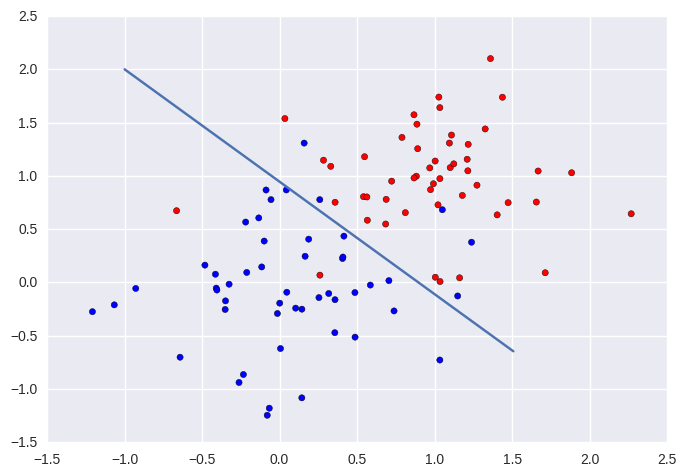

In [10]:
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

vec_colour = np.vectorize(lambda x: ['#0000FF','#FF0000'][int(x)])  # Transform the labels to colours
colour_labels = vec_colour(labels)
plt.scatter(points[:,0], points[:,1], c=colour_labels)
#plt.plot([-1,2], [2,-1])  # This is the line we want a classifier to find
plt.plot(l0, l1)
plt.show()

### Next Objectives
#### Get a better handle on TensorBoard reporting  
Want to see the loss and the trainable parameters at the very least.  Eventually we'll add learning rates, kernels, etc.
#### Keep a roster of the top performers
Keep snapshots of the networks corresponding to local minima in the training loss.  Make it easy to load those snapshots.  Once we suspect we're beginning to overtrain the network, we can load up those "training highlights", cross-validate them, and package up the best one for "release" (e.g. Kaggle submission).

# Appendix (under construction)

The gradient of the loss is, therefore,
$$\begin{eqnarray}
\nabla_{\boldsymbol \theta} \ell(\mathbf p) &=& \left(\frac \partial {\partial \theta_0} \ell(\mathbf p), \frac \partial {\partial \theta_1} \ell(\mathbf p), \frac \partial {\partial \theta_2} \ell(\mathbf p)\right)\\
\end{eqnarray}$$

$$
\begin{align*}
H(y,h_{\boldsymbol \theta} (\mathbf p)) &= -\sum_{i=0}^1 P(y=i \mid y) \log P(y=i \mid \mathbf p; \boldsymbol \theta)\\
&= -(1-y) \log P(y=0 \mid \mathbf p; \boldsymbol \theta) - y \log P(y=1 \mid \mathbf p; \boldsymbol \theta)\\
&= -(1-y) \log \left(1-h_{\boldsymbol \theta} (\mathbf p)\right) - y \log h_{\boldsymbol \theta} (\mathbf p)\\
&= -(1-y) \log \left(1-\frac 1 {1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}} \right) - y \log \frac 1 {1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}}\\
&= -(1-y) \log \left(\frac {e^{-\langle \boldsymbol \theta, \mathbf p\rangle}} {1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}} \right) - y \log \frac 1 {1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}}\\
&= (y-1) \left[ \log e^{-\langle \boldsymbol \theta, \mathbf p\rangle} - \log \left(1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}\right) \right] + y \left[ \log \left(1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}\right) \right]\\
&= y \log e^{-\langle \boldsymbol \theta, \mathbf p\rangle} - y \log \left(1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}\right) - \log e^{-\langle \boldsymbol \theta, \mathbf p\rangle} + \log \left(1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}\right) + y \log \left(1+e^{-\langle \boldsymbol \theta, \mathbf p\rangle}\right)\\
&= (y-1) \log e^{-\langle \boldsymbol \theta, \mathbf p\rangle} + \log \left(1 + e^{-\langle \boldsymbol \theta, \mathbf p\rangle}\right)
\end{align*}
$$
